# Solving Recurrent Models via Convex Programming
## Sohail Bahmani
### Jul 17, 2019

This IJulia notebook provides an implementation of the method proposed in the paper:
> &ldquo;[_Convex programming for estimation in nonlinear recurrent models_](https://arxiv.org/abs/1908.09915),&rdquo; ``arXiv: 1908.0995 [stat.ML]``.

## Load packages

In [1]:
using LinearAlgebra, Plots, Random, LaTeXStrings, Statistics
gr();
default(show = true);

## Define the recurrent model
\\[\boldsymbol{x}_t=\nabla f(\boldsymbol{A}_\star \boldsymbol{x}_{t-1}+\boldsymbol{B}_\star \boldsymbol{u}_{t-1})\\]

In [43]:
ρ = 1;
f = z -> 0.5*(1-ρ)*norm(max.(z,0))^2 + 0.5*ρ*norm(z)^2;
∇f = z -> (1-ρ)*max.(z,0) + ρ*z; #log(1+exp((z-abs(z)))) + abs(z); #atan(5z)*2/π; #max(z,0); #atan(5*z)*2/π; 0.2log(1+exp(5*(z-abs(z)))) + abs(z)

function createModel(n,m,T,α)
    
    A = randn(n,n);
    A = svd(A).U;
    A = α*A;
    B = randn(n,m);
    C = [A B];
    
#     U = randn(m,T+1); # Gaussian model
    U = randn(m,T+1).^3; # Heavy-tailed model
    Z = [zeros(n,T+1); U];

    for t = 1:T
        Z[1:n,t+1] = ∇f(C*Z[:,t]);
    end

    Σ = D -> (D*D')/size(D,2);
    β = sqrt(opnorm(Σ(Z[1:n,:]))/opnorm(Σ(U)));

    Z = [ones(n); β*ones(m)] .* Z;
    C = C .* [ones(n); ones(m)/β]';

    L = (Θ,S) -> (sum(mapslices(f, Θ*Z[:,S], dims = 1)) - dot(Z[1:n,S.+1], Θ*Z[:,S]))/length(S);
    ∇L = (Θ,S) -> (mapslices(∇f, Θ*Z[:,S], dims = 1) * transpose(Z[:,S]) - Z[1:n,S.+1]*transpose(Z[:,S]))/length(S);
    
    return (n, m, T, Z, C, L, ∇L)
end

The estimator is formulated as:
\\[\widehat{\boldsymbol{C}} = \operatorname*{argmin}_{\boldsymbol{C}}\ \sum_{t=1}^T f(\boldsymbol{C}\boldsymbol{z}_{t-1})-\langle\boldsymbol{x}_t,\boldsymbol{C}\boldsymbol{z}_{t-1}\rangle\,.\\]
***
## Solve by Accelerated GD

In [ ]:
n_trial = 100;
δf = [[] for i in 1:n_trial];

for trial = 1:n_trial
    n, m, T, Z, C, L, ∇L = createModel(50,100,500,0.2)#,f,∇f);
        
    δf[trial] = 1e-8 .+ zeros(T);
    
    Ĉ = zeros(n, m+n);
    η = 1e-4;
    Ĉp = Ĉ;
    λ = 0;
        
    count = T;
    for t = 1:T
    #     global L, ∇L, Ĉ, Ĉp, η, λ;

        λp = 0.5 + sqrt(0.25 + λ^2);
        γ = (1-λ)/λp;
        λ = λp;
                
        Ĉpp = Ĉ - η*∇L(Ĉ,1:T);
        Ĉ = (1-γ)*Ĉpp + γ*Ĉp;
        Ĉp = Ĉpp;
        
        if sum(isnan.(Ĉ)) > 0
            println("NaN detected!!! possibly large step size.");
            break;
        end
                
        δf[trial][t] = norm(Ĉ-C)^2/norm(C)^2;
        if δf[trial][t] < 1e-8
            count = t;
            break;
        end
    end
    IJulia.clear_output(true);
    println("trial#: ", trial, " t_end: ", count);
end

## Solve by SGD

In [ ]:
# Ĉ = zeros(n, m+n);
# ℓ_batch = 1;
# n_batch = Int64(floor(T/ℓ_batch));
# t = 0;
# η = 3e-5;
# plt_SGD = scatter([0],[1],legend=false, xlabel = "Iteration", ylabel = L"\frac{\Vert \widehat{C}-C_\star\Vert^2_{\scriptstyle{\textup{F}}}}{\Vert C_\star\Vert^2_{\scriptstyle{\textup{F}}}}", ylim = [1e-8 1], xlim=[1 T], yscale= :log10);
# for epoch in 1:Int64(floor(100/ℓ_batch))
#     SGD_cycle = randperm(T);
#     for batch in [SGD_cycle[(i-1)*ℓ_batch+1:i*ℓ_batch] for i in 1:n_batch]
#         Ĉ = Ĉ - η*∇L(Ĉ, batch)

#         δf = norm(Ĉ-C)^2/norm(C)^2;
#         t += 1;
#         display(scatter!(plt_SGD, [t],[δf], color = RGBA(0,0.8,0.6,0.5) ,markersize = 4, markerstrokewidth = 0, legend=false));
#         IJulia.clear_output(true);
#         if δf < 1e-8
#             break;
#         end
#     end
# end

## Plot Relative Error

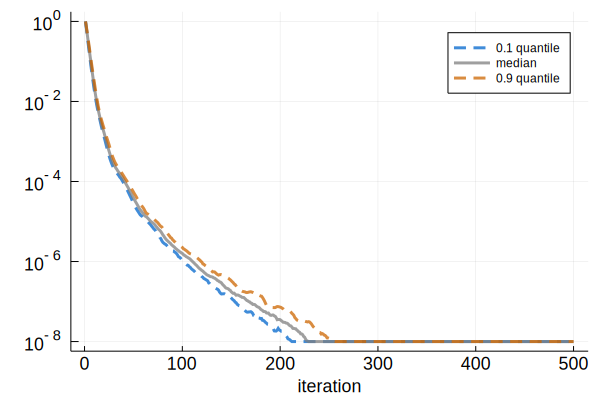

In [47]:
Q = p -> quantile.([[(δf[i])[j] for i in 1:n_trial] for j in 1:T],p);
display(plot(1:T, [Q.([0.1 0.5 0.9])...] , seriescolor = [RGBA(0,0.4,0.8,0.75) RGBA(0.5,0.5,0.5,0.75)  RGBA(0.8,0.4,0,0.75)]
                                    , label= ["0.1 quantile" "median"  "0.9 quantile"]
                                    , linestyle=[:dash :solid  :dash]
                                    , linewidth = 3
                                    , yaxis = (#L"\frac{\Vert \widehat{C}-C_\star\Vert^2_{\textup{\scriptsize F}}}{\Vert C_\star\Vert^2_{\textup{\scriptsize F}}}", 
                                                :log10,
                                               font(12,"Calibri"))
                                    , xaxis = ("iteration", font(12, "Calibri"))
            )
    );
savefig("Convex-RNN.svg")